<a href="https://colab.research.google.com/github/neennera/AI_pitch/blob/main/Feat_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import torchvision.models as models


import pandas as pd
import torchaudio
import pickle
import numpy as np
from tqdm.auto import tqdm

# DataLoader

In [2]:
#import zipfile
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install patool
!pip install pyunpack
from pyunpack import Archive
Archive("/content/gdrive/MyDrive/AI/wav.rar").extractall("/content/")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
classmap=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
#df = pd.read_csv("/content/gdrive/MyDrive/AI/labels.csv")

In [5]:
#from sklearn.model_selection import train_test_split
#train_df, test_df = train_test_split(df, test_size=0.2)
train_df = pd.read_csv("/content/gdrive/MyDrive/AI/train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/AI/test.csv")

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

target_sample_rate=16000.0
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=34624,
    n_mels=254,
    n_fft=2048,
    hop_length=512
)
mel_spectrogram.to(device)

def resample_if_necessary(signal, sr):
  if sr != target_sample_rate:
      resampler = torchaudio.transforms.Resample(sr, target_sample_rate)
      signal = resampler(signal)
  return signal

def mix_down_if_necessary(signal):
  if signal.shape[0] > 1:
      signal = torch.mean(signal, dim=0, keepdim=True)
  return signal

def transformation(signal):
  mel_spectrogram

In [7]:
class CustomTrainDataset(Dataset):
    def __init__(self, feat_path=train_df["wav_path"], transform=None, target_transform=None):
        self.label = train_df["label"]
        self.feat_path = feat_path
        self.path = "/content/wav/"

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        path = self.path +self.feat_path[idx]+'.wav'
        signal, sr = torchaudio.load(path)
        signal = resample_if_necessary(signal, sr)
        signal = mix_down_if_necessary(signal)
        data = mel_spectrogram(signal)
        data = data[0]
        label = classmap.index(self.label[idx])
        return data, label

class CustomTestDataset(Dataset):
    def __init__(self, feat_path=test_df["wav_path"] , transform=None, target_transform=None):
        self.label = test_df["label"]
        self.feat_path = feat_path 
        self.path = "/content/wav/"

    def __len__(self):
      return len(self.label)

    def __getitem__(self, idx):
        path = self.path +self.feat_path[idx]+'.wav'
        signal, sr = torchaudio.load(path)
        signal = resample_if_necessary(signal, sr)
        signal = mix_down_if_necessary(signal)
        data = mel_spectrogram(signal)
        data = data[0]
        label = classmap.index(self.label[idx])
        return data, label

train_dataset=CustomTrainDataset()
test_dataset=CustomTestDataset()

#Model

In [8]:
class Model(nn.Module):
    def __init__(self, feat_dim=256):
        super(Model, self).__init__()

        # wav2letter architecture
        self.convo1 = self._get_conv_block(254, 256, 7)
        self.convo2 = self._get_conv_block(256, 256, 7)
        self.convo3 = self._get_conv_block(256, 512, 7)
        self.convo4 = self._get_conv_block(512, 512, 7)
        self.convo5 = self._get_conv_block(512, 2048, 32)
        self.convo6 = self._get_conv_block(2048, 2048, 1)
        #self.convo7 = self._get_conv_block(2048, 12, 1, activation="sigmoid")
        self.convo7 = self._get_conv_block(2048, 12, 1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(512* 50, 12)

    def _get_activation(self, name):
      if name == "relu":
        return nn.ReLU()
      elif name == "softmax":
        return nn.Softmax(dim=1)
      elif name == "sigmoid":
        return nn.Sigmoid()


    def _get_conv_block(self, in_channel, out_channel, kernel_size, activation="relu"):
      return nn.Sequential(
          nn.Conv1d(in_channel, out_channel, kernel_size, padding="same"),
          nn.BatchNorm1d(out_channel),
          self._get_activation(activation)
      )

    def forward(self, x):
        #x = torch.transpose(x, 1, 2)  # reformat from (B, T, C) to (B, C, T)
        x = self.convo1(x)   # (B, C=120, T=1500) -> (B, C=conv1_out_dim, T=1500)
        x = self.convo2(x)
        x = self.convo3(x)
        x = self.convo4(x)
        #x = self.convo5(x)
        #x = self.convo6(x)
        #x = self.convo7(x)
        #print(x.size())
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [9]:
model = Model()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 3e-4)

checkpoint = { 
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

In [10]:
def save(train_losses,metrics_train,test_losses,metrics_test,i):
    loss_log_test=[]
    acc_log_test=[]
    loss_log_train=[]
    acc_log_train=[]
    
    path='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)+'/checkpoint.pth'
    path_log='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)
    path_old='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i-1)
    torch.save(checkpoint, path)
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)+'/model_weight.pth')

    if(i>1):
      with open(path_old+'/loss_log_test.pkl', 'rb') as f:
          loss_log_test = pickle.load(f)
      with open(path_old+'/acc_log_test.pkl', 'rb') as f:
          acc_log_test = pickle.load(f)  
      with open(path_old+'/loss_log_train.pkl', 'rb') as f:
          loss_log_train = pickle.load(f)
      with open(path_old+'/acc_log_train.pkl', 'rb') as f:
          acc_log_train = pickle.load(f)    

    for k in test_losses :
        loss_log_test.append(k)
    acc_log_test = acc_log_test + metrics_test

    for k in train_losses :
        loss_log_train.append(k)
    acc_log_train = acc_log_train + metrics_train

    with open(path_log+'/loss_log_train.pkl', 'wb') as f:
        pickle.dump(loss_log_train, f)
    with open(path_log+'/acc_log_train.pkl', 'wb') as f:
        pickle.dump(acc_log_train, f)
    with open(path_log+'/loss_log_test.pkl', 'wb') as f:
        pickle.dump(loss_log_test, f)
    with open(path_log+'/acc_log_test.pkl', 'wb') as f:
        pickle.dump(acc_log_test, f)

In [11]:
from sklearn.metrics import confusion_matrix, precision_score,accuracy_score
#loss_fn = nn.MSELoss()
loss_fn = nn.CrossEntropyLoss()
def M_loss_func(pred, target):
  """k = len(target)
  targets = torch.from_numpy(np.zeros((k,107), dtype="float32"))
  for i in range(k) :
    targets[i][target[i]] = 1.0"""
  
  #pred = pred.argmax(dim=1)
  #preds = torch.tensor(pred,dtype=torch.long).view(-1)
  #target = torch.tensor(target,dtype=torch.long).view(-1)
  return loss_fn(pred,target)

def M_accuracy(pred,target):
  #tn, fp, fn, tp = confusion_matrix(y_true, y_pred_class).ravel()
  pred = pred.argmax(dim=1).detach().numpy()
  return accuracy_score(target, pred)
  #return precision_score(target, preds,average='micro')

In [ ]:
'''model=Model()
yhatb = model(xb)
loss = M_loss_func(yhatb, yb)
acc = M_accuracy(yhatb, yb)'''

NameError: ignored

# Training loop

In [12]:
batch_size = 128
epochs = 10
lr = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
def get_epoch(k, train_dataloader, val_dataloader, batch_size,st,ed):
    print("epoch","\t train loss \t accuracy \t\t val loss \t\t val accuracy")
    train_loss ,train_acc, val_loss=0,0,0
    for i in range(st,ed+1) :
        train_epoch(i, train_dataloader, val_dataloader, batch_size)
        #torch.save(model.state_dict(), "weight/convo2/mymodel.pt")

def train_epoch(k, train_dataloader, val_dataloader, batch_size):
    model.train()
    train_batch_loss = []
    train_batch_acc = []
    for batch in tqdm(train_dataloader):
        xb, yb = batch
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        yhatb = model(xb)

        loss = M_loss_func(yhatb, yb)
        acc = M_accuracy(yhatb, yb)
        loss.backward()
        optimizer.step()

        train_batch_loss.append(loss.detach().cpu().numpy())
        train_batch_acc.append(acc)

    train_loss = np.mean(train_batch_loss)  # average train loss among all batches
    train_acc = np.mean(train_batch_acc)  # average acc among all batches     

    val_batch_loss = []
    losses=[]
    metrics=[]
    for batch in tqdm(val_dataloader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        # we don't need to calculate gradients when evaluating
        with torch.no_grad():
            yhatb = model(x)  # forward propagation
            loss = M_loss_func(yhatb, y)  # compute val loss
            acc = M_accuracy(yhatb, y)
            losses.append(loss.detach().cpu())
            metrics.append(acc)
        val_batch_loss.append(loss.cpu().numpy())
    val_loss = np.mean(val_batch_loss)
    val_acc = np.mean(metrics)
    save(train_batch_loss,train_batch_acc, losses,metrics,k)
    print(k, "\t", train_loss , "\t", train_acc,"\t", val_loss, "\t" , val_acc)

In [14]:
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=batch_size)
for batch in tqdm(val_dataloader):
    xb, yb = batch
    break

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
model = Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
i=5
model.load_state_dict(torch.load('/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)+'/model_weight.pth'))
model = model.to(device)
model.train()

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, num_workers=0)
get_epoch(15, train_dataloader, test_dataloader, batch_size,5,9)

epoch 	 train loss 	 accuracy 		 val loss 		 val accuracy


  0%|          | 0/167 [00:00<?, ?it/s]

# Graph

In [46]:
loss_log=[]
acc_log=[]
i=5

path='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i-1)+'/checkpoint.pth'
path_log='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)
path_old='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i-1)

with open(path_log+'/loss_log_train.pkl', 'rb') as f:
    loss_log_train = pickle.load(f)
with open(path_log+'/acc_log_train.pkl', 'rb') as f:
    acc_log_train = pickle.load(f)
with open(path_log+'/loss_log_test.pkl', 'rb') as f:
    loss_log_test = pickle.load(f)
with open(path_log+'/acc_log_test.pkl', 'rb') as f:
    acc_log_test = pickle.load(f)

In [19]:
len(loss_log_train)

501

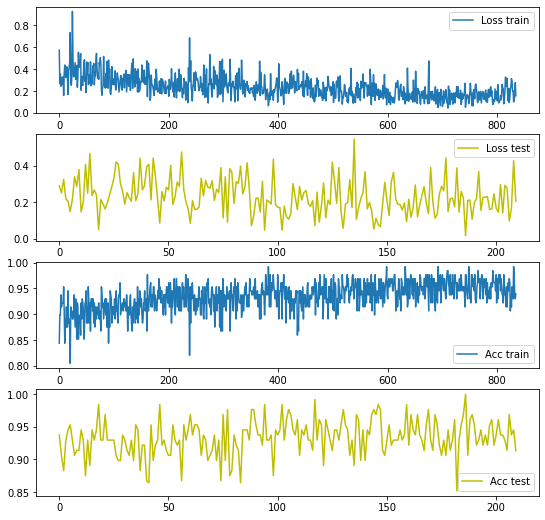

In [47]:
import matplotlib.pyplot as plt
t = torch.arange(len(loss_log_train)).numpy()
k = torch.arange(len(loss_log_test)).numpy()

fig,ax = plt.subplots(4,1,figsize=(9, 9))
ax[0].plot(t, loss_log_train, label="Loss train")
ax[1].plot(k, loss_log_test, label="Loss test", color="y")
ax[2].plot(t, acc_log_train, label="Acc train")
ax[3].plot(k, acc_log_test, label="Acc test", color="y")

for i in range(4):
  ax[i].legend()

# Predict



In [30]:
model = Model()
model = model.to(device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
i=3
path='/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)+'/checkpoint.pth'

checkpoint = { 
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [33]:
model = Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
i=3
model.load_state_dict(torch.load('/content/gdrive/MyDrive/AI/weight/con_wev/'+str(i)+'/model_weight.pth'))
model = model.to(device)
model.eval()

Model(
  (convo1): Sequential(
    (0): Conv1d(254, 256, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convo2): Sequential(
    (0): Conv1d(256, 256, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convo3): Sequential(
    (0): Conv1d(256, 512, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convo4): Sequential(
    (0): Conv1d(512, 512, kernel_size=(7,), stride=(1,), padding=same)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convo5): Sequential(
    (0): Conv1d(512, 2048, kernel_size=(32,), stride=(1,), padding=same)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_runni

In [31]:
def predict(model, input, target, class_mapping) :
  model.eval() #เป็นสวิตท์ model.eval() ใช่ในการทาย // model.train() ใช้ในการเทรน
  
  with torch.no_grad(): #ใช้ model แบบไม่คำนวน grad
    pred = model(input)
    #จะ map ไปเป็น class โดย pred อยู่ในรูป (batch, number , class) -> (1,1,10)
    pred_index = (pred.argmax(dim=1)).to(dtype=int)
        # pred[0] เอามาแค่ตัวแรก
        # argmax(0)  เลือกเอาอากิวเมนต์ที่มีค่าสูงสุด [เพราะ softmax ทำนายออกมาเป็น % ความน่าจะเป็น]
    preds=[]
    expected=[]
    print(f"Accuracy : {M_accuracy(pred,target)*100}")
    for i in range(len(pred_index)) :
      preds.append(class_mapping[pred_index[i]])
      expected.append(class_mapping[target[i]])
  return preds, expected

In [34]:
from sys import breakpointhook

batch_size=128
validation=DataLoader(test_dataset, batch_size=batch_size)
for batch in tqdm(validation):
    xb, yb = batch
    break
  
predicted, expected = predict(model, xb, yb, classmap)
for i in range(20) :
    print(f"Predicted: '{predicted[i]}', expected: '{expected[i]}'")

  0%|          | 0/42 [00:00<?, ?it/s]

Accuracy : 94.53125
Predicted: 'F#', expected: 'F#'
Predicted: 'A#', expected: 'A#'
Predicted: 'B', expected: 'B'
Predicted: 'C', expected: 'C'
Predicted: 'B', expected: 'B'
Predicted: 'F', expected: 'F'
Predicted: 'F#', expected: 'F#'
Predicted: 'A#', expected: 'A#'
Predicted: 'A', expected: 'A'
Predicted: 'B', expected: 'B'
Predicted: 'F', expected: 'F'
Predicted: 'F#', expected: 'F#'
Predicted: 'G', expected: 'G'
Predicted: 'C', expected: 'C'
Predicted: 'F', expected: 'F'
Predicted: 'D', expected: 'D'
Predicted: 'B', expected: 'B'
Predicted: 'F', expected: 'F'
Predicted: 'C', expected: 'C'
Predicted: 'E', expected: 'E'
